# Model Quantization

<a target="_blank" href="https://colab.research.google.com/github/yandexdataschool/nlp_course/blob/2025/week08_efficiency/hw_8.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this session, you're going to implement post-training quantization approaches for _Large Language Models_, ranging from naive ones to State of The Art techniques. The main goal is to implement [GPTQ](https://arxiv.org/abs/2210.17323), with some of it's newer extension left as bonus exercises.

<font color='red'>Important note:</font>
This homework is designed to run on colab with T4 gpu. It requires at least 15Gb of *VRAM*, 12Gb of *RAM*. If your machine meets those criteria, you should be good to go too.



# Installing the Dependencies

In [2]:
%pip install transformers==4.57.1 sentencepiece==0.2.1 datasets==4.0.0 accelerate==1.11.0 Ninja==1.13.0 triton==3.4.0

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 809.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 134.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.2

In [3]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 856.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.2 MB

### Imports

In [4]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0 # Change it if you're on a multy-GPU machine

import os
import math
import random
from tqdm.notebook import tqdm, trange
from typing import Mapping
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers.models.llama.modeling_llama import LlamaDecoderLayer, LlamaForCausalLM
from transformers.models.llama.configuration_llama import LlamaConfig
from transformers import AutoTokenizer
from datasets import load_dataset

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0 # Change it if you're on a multy-GPU machine


**INT8 and INT4 GEMM custom CUDA kernels**

Along with this jupyter notebook, two `CUDA` files are provided, implementing efficient matrix multiplication for `int4` and `int8`.

In [5]:
!git clone https://github.com/NVIDIA/cutlass.git
!export CUDACXX=/usr/local/cuda/bin/nvcc
!cd cutlass && mkdir build && cd build && cmake .. -DCUTLASS_NVCC_ARCHS=75

!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/kernel.cpp --no-check-certificate
!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/kernel.cu --no-check-certificate

Cloning into 'cutlass'...
remote: Enumerating objects: 36573, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 36573 (delta 41), reused 27 (delta 27), pack-reused 36503 (from 2)
Receiving objects: 100% (36573/36573), 54.85 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (27582/27582), done.
Updating files: 100% (6708/6708), done.
-- CMake Version: 3.31.6
-- CUTLASS 4.3.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- The CUDA compiler identification is NVIDIA 12.5.82 with host compiler GNU 11.4.0
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile featur

In [6]:
from torch.utils.cpp_extension import load

custom_kernel = load(name='custom_kernel', sources=['kernel.cpp', 'kernel.cu'], extra_include_paths=[r"cutlass/include"])

/usr/local/lib/python3.12/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Usage: `output = custom_kernel.int8_matmul(X, Y)` and `output = custom_kernel.int4_matmul(X, Y)` compute $XY^T$ (same as `nn.functional.linear`).

Notice that `int8_matmul` takes the normal `torch.int8` tensors, but int4_matmul expects `int4` values densely packed into `torch.uint8` tensors. This is exactly what we wrote **Dense Integer Packing** for. They have a <font color='red'>severe limitation</font>: the dimension of multiplication must be divisible by 16.

Now you have to implement the quantized forward pass:

 $$
 \begin{align}
    XW^T &= (Q_x \cdot scale_x + zero_x \cdot scale_x)(Q_w \cdot scale_w + zero_w \cdot scale_w)^T =\\
    &= (Q_x  + zero_x)(Q_w + zero_w)^T \cdot (scale_x \odot scale_w^T) =\\
    &= (Q_xQ_w^T + Q_x zero_w^T + zero_x Q_w^T + zero_x zero_w^T) \cdot (scale_x \odot scale_w^T)
 \end{align}
 $$

because of the kernel limitations mentioned above, only the largest integer multiplication ($Q_xQ_w^T$) can be done in `int`. Perform the other ones in `float`.

In [7]:
MODEL_NAME = "NousResearch/Llama-3.2-1B"

def get_llama_model_and_tokenizer():
    model = LlamaForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="cpu", dtype=torch.float16,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    model.config.pad_token_id = model.config.eos_token_id
    tokenizer.pad_token_id = tokenizer.eos_token_id

    return model, tokenizer

# GPUs, Throughput and Quantization

Torch natively supports `int8`, but not `int4`. For the most part, we will `torch.uint8` to represent tensors quantized to *4 bits*. We encoded each *4-bit* value with an *8-bit* value, using twice as much memory as we really needed. We did this because `torch` lacks support for 4-bit tensors. However, we never performed any native operations in *8 bits*; we always converted it to `torch.float16` first. That means we can design a more efficient way to encode *4-bit* tensors and convert to and from it.

Your task is to implement these conversions, converting *8-bit* tensors containing *4-bit* values (the way we used to store quantized weights) to and from smaller *8-bit* tensor, utilizing the whole range of values. Moreover, you'll have to do it in a way such that memory representation of contiguous arrays wouldn't change. That is, adjacent columns get squashed together.

**Task (1.0pt):** Implement dense *int4*:

In [8]:
def dense_pack_4_8(x: Tensor) -> Tensor:
    """Constructs a densely packed int tensor
    Args:
        x (Tensor): uint8 with uint4 values range

    Returns:
        Tensor: twice as small uint8 tensor with uint8 values range
    """
    x = x.clone().detach()
    return x[...,::2] * 16 + x[..., 1::2]

def dense_unpack_4_8(x: Tensor) -> Tensor:
    """Deconstructs a densely packed int tensor
    Args:
        x (Tensor): uint8 tensor with uint8 values range

    Returns:
        Tensor: twice as large int8 tensor with uint4 values range
    """
    x = x.clone().detach()
    res = torch.empty(x.shape[:-1] + (x.size(-1) * 2,), device=x.device, dtype=torch.uint8)
    res[..., ::2] = x // 16
    res[..., 1::2] = x % 16
    return res



In [9]:
# Testing your code

quantized_x = torch.randint(0, 16, (512 * 1024,)).reshape(512, 1024).float()
dense_quantized_x = dense_pack_4_8(quantized_x)
undense_quantized_x = dense_unpack_4_8(dense_quantized_x)

assert dense_quantized_x.shape == (512, 512)
assert torch.all(undense_quantized_x == quantized_x)
assert torch.all(dense_unpack_4_8(dense_pack_4_8(quantized_x[:8,:8])) == dense_unpack_4_8(dense_pack_4_8(quantized_x)[:8,:4])), "Adjacent values shall be packed"
print("All tests passed!")

All tests passed!


Now we can benchmark the quantized GEMM kernels to estimate the speedups:

In [10]:
from triton.testing import do_bench

HIDDEN_SIZE = 4096
NUM_REPEATS = 1024

B_fp16 = torch.randint(0, 16, (HIDDEN_SIZE, HIDDEN_SIZE), dtype=torch.float16, device="cuda")
B_int8 = B_fp16.to(torch.int8)
B_int4 = dense_pack_4_8(B_int8)

fp16_latencies = {}
int8_latencies = {}
int4_latencies = {}

with torch.no_grad():
    for BATCH_SIZE in tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256, 512], desc="Iterating BATCH_SIZE"):
        A_fp16 = torch.randint(0, 16, (BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float16, device="cuda")
        A_int8 = A_fp16.to(torch.int8)
        A_int4 = dense_pack_4_8(A_int8)

        fp16_latencies[BATCH_SIZE] = do_bench(lambda: torch.nn.functional.linear(A_fp16, B_fp16, None), rep=500)
        int8_latencies[BATCH_SIZE] = do_bench(lambda: custom_kernel.int8_matmul(A_int8, B_int8), rep=500)
        int4_latencies[BATCH_SIZE] = do_bench(lambda: custom_kernel.int4_matmul(A_int4.view(torch.uint8), B_int4.view(torch.uint8)), rep=500)

Iterating BATCH_SIZE:   0%|          | 0/10 [00:00<?, ?it/s]

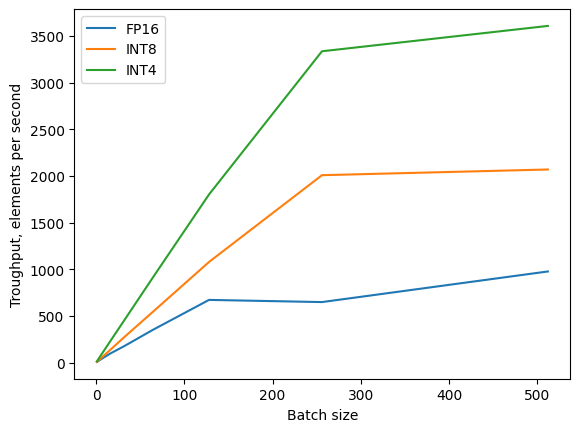

In [11]:
import matplotlib.pyplot as plt

plt.plot(fp16_latencies.keys(), [key/val for key, val in fp16_latencies.items()], label="FP16")
plt.plot(int8_latencies.keys(), [key/val for key, val in int8_latencies.items()], label="INT8")
plt.plot(int4_latencies.keys(), [key/val for key, val in int4_latencies.items()], label="INT4")
# plt.xscale("log")

plt.xlabel("Batch size")
plt.ylabel("Troughput, elements per second")

plt.legend()
plt.show()

It's easy to see that the speedup is ~2x for INT8 and ~4x for INT4 compared to FP16 for all batch sizes!

# Speculative Decoding

### Throughput Benchmarking

In [12]:
model, tokenizer = get_llama_model_and_tokenizer()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

**Compile model forward for more accurate benchmarks**

`transformers` is not a very efficient inference engine because of high python overhead and almost no kernel optimization.

However, with `PyTorch` `v2.0.0`, [`torch.compile`](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) was introduced. This feature allows for capturing, isolating and optimizing CUDA runtime in `PyTorch`. Using this feature, we can effectively eliminate almost all python overhead and optimize the kernels.

Starting with [`transformers` `v4.44.0`](https://github.com/huggingface/transformers/releases/tag/v4.44.0), this feature is integrated with `transformers` text generation utils end-to-end. However, for simplicity, we'll apply it to the forward pass of the model specifically.

In [13]:
model = model.to("cuda")
model.forward = torch.compile(
    model.forward,          # the function call to compile
    fullgraph=True,         # Compile all the CUDA kernels into a single entity
    mode="reduce-overhead", # Optimize for speed
)

**Benchmark forward passes with different seq_len**

Run the following cell 2+ times. The first time is slow because that's when the compilation is taking place.

The following runs are much faster.

(EXTRA: run this cell without compiling to measure scompilation speedup)

In [14]:
from time import perf_counter

NUM_REPEATS = 100

throughpus = {}

for seq_len in [1, 2, 4, 8, 16, 32, 64]:
    input_ids = torch.randint(0, tokenizer.vocab_size, (1, seq_len)).to("cuda")

    with torch.no_grad():
        for _ in range(10):
            model(
                input_ids,
                use_cache=False,
            )
            torch.cuda.synchronize()

        start = perf_counter()
        for _ in range(NUM_REPEATS):
            model(
                input_ids,
                use_cache=False,
            )
            torch.cuda.synchronize()
        end = perf_counter()
    throughpus[seq_len] = NUM_REPEATS * seq_len / (end - start)
    print(f"{seq_len} tokens: {NUM_REPEATS / (end - start):.2f} passes/s")

1 tokens: 88.22 passes/s
2 tokens: 81.04 passes/s
4 tokens: 80.07 passes/s
8 tokens: 78.49 passes/s
16 tokens: 73.04 passes/s
32 tokens: 64.66 passes/s
64 tokens: 61.04 passes/s


As we can see, the forward pass speed almost doesn't depend on the number of tokens passed through the model up to around **16** tokens at a time.

Text(0, 0.5, 'Troughput, tokens per second')

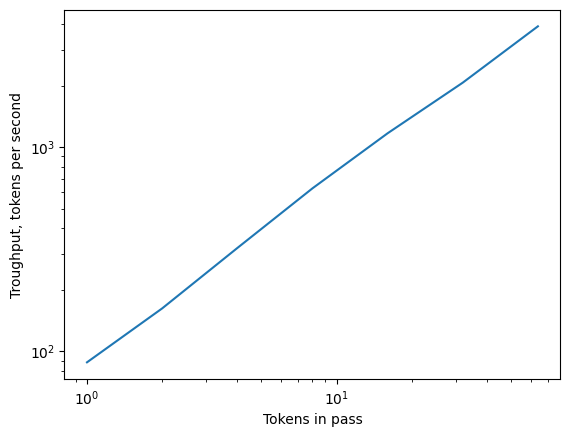

In [15]:
import matplotlib.pyplot as plt

plt.plot(throughpus.keys(), throughpus.values())
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Tokens in pass")
plt.ylabel("Troughput, tokens per second")

In [16]:
del model

## Speculative Decoding

As a baseline, we'll generate hypotheses using a very simple bigram model.

### Load the Data

We'll use the [wikitext2](https://paperswithcode.com/dataset/wikitext-2) dataset as a sample of natural language.

In [17]:
import random

from datasets import load_dataset

SEED = 0

def get_wikitext2(seed, seqlen, nsamples=64):
    traindata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
    testdata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    train_input_ids = tokenizer("\n\n".join(traindata['text']), return_tensors='pt').input_ids
    random.seed(seed)
    train_batch = []
    for _ in range(nsamples):
        i = random.randint(0, train_input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = train_input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        train_batch.append(inp[0])

    test_input_ids = tokenizer("\n\n".join(testdata['text']), return_tensors='pt').input_ids
    test_input_ids = test_input_ids[:, :(test_input_ids.shape[1] // seqlen) *  seqlen]
    test_input_ids = test_input_ids.reshape(test_input_ids.shape[1] // seqlen, seqlen)

    return torch.stack(train_batch), test_input_ids

train_batch, test_input_ids = get_wikitext2(SEED, 8192)

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


**Task (1.0pt):** Build a bigram model

Using sequences from `train_batch`, build a bigram model for predicting `n` tokens into the future.

WARNING: torch.Tensors have weird interactions with dicts and Counters. use `.item()`

In [18]:
from tqdm.auto import tqdm, trange

from typing import Mapping


import numpy as np
from collections import defaultdict, Counter

def build_next_token_array(train_data, vocab_size: int=128256, default_next_token: int=220) -> Mapping[int, int]:
    """
    Builds an array mapping each token in the vocabulary to its most likely next token based on training data.

    Args:
        train_data (torch.Tensor): Array of training data tokens.
        vocab_size (int): The size of the vocabulary.
        default_next_token (int): Default token to use if no next token can be determined.

    Returns:
        Mapping[int, int]: Array where each index represents a token and the value at that index is the most likely next token.
    """
    # YOUR CODE HERE>>>>>>>>>
    # Step 1: Prepare the Data
    # Convert tensor to a list of integers for easier processing
    if isinstance(train_data, torch.Tensor):
        tokens = train_data.flatten().cpu().tolist()
    else:
        tokens = train_data.flatten() if hasattr(train_data, 'flatten') else train_data

    # Step 2: Create Pairs and Count Occurrences
    # Count bigram occurrences: (current_token, next_token) -> count
    bigram_counts = defaultdict(lambda: defaultdict(int))
    for i in range(len(tokens) - 1):
        current_token = int(tokens[i])
        next_token = int(tokens[i + 1])
        bigram_counts[current_token][next_token] += 1

    # Step 3: Build Mapping from Current Token to Next Token Counts
    # Step 4: Determine the Most Likely Next Token
    # For each token, find the next token with maximum count
    next_tokens_array = [default_next_token] * vocab_size

    for current_token in range(vocab_size):
        if current_token in bigram_counts:
            # Find the next token with maximum count
            next_token_counts = bigram_counts[current_token]
            if next_token_counts:
                most_likely_next = max(next_token_counts.items(), key=lambda x: x[1])[0]
                next_tokens_array[current_token] = most_likely_next

    # <<<<<<<<<<<<<<<<<<<<<<<

    return next_tokens_array

def speculate_bigram(input_ids: torch.Tensor, position: int, n: int, next_tokens_array: Mapping[int, int]) -> int:
    """
    Generates a speculative sequence by predicting next tokens in a sequence using a bigram model.

    Args:
        input_ids (torch.Tensor): Tensor of input token IDs.
        position (int): Position in the sequence to begin speculation.
        n (int): Number of tokens to generate.
        next_tokens_array (Mapping[int, int]): Mapping of tokens to their most likely next token.

    Returns:
        int: Number of tokens generated.
    """
    for i in range(n):
        hypo_next_token = next_tokens_array[input_ids[0, position - 1].item()]
        input_ids[0, position] = hypo_next_token
        position += 1
    return n


NEXT_TOKEN_WIKI2 = build_next_token_array(train_batch.flatten())

**Task (2.0pt):** Implement greedy sequential speculative decoding:

You're given a prototype of the function that generate a token sequence greedily by speculating `n` tokens into the fulure and verifying those tokens.

Your task is to:
 * Correctly fill a hypothesis inplace (using `speculate_fn`)
 * Pass the hypothesis through the model (with correct `past_key_values`)
 * Find where the hypothesis diverges.
 * Update the current position in the generation, as well as the number of forward pass calls.

In [19]:
model, tokenizer = get_llama_model_and_tokenizer()
model = model.to("cuda")

In [20]:
from transformers import StaticCache


def truncate_past_key_values(past_key_values, position):
    """
    Truncates the past key and value caches at a specific position. `transformers`-specific stuff. Might change with their next update.

    Args:
        past_key_values (object): Object containing key and value caches for each layer.
        position (int): Position from which to truncate the caches.
    """
    for layer in past_key_values.layers:
        layer.keys[:,:,position - 1:] = 0.0
        layer.values[:,:,position - 1:] = 0.0


def generate_speculative(model, tokenizer, num_tokens_to_generate: int, speculate_fn: callable, max_speculated_len: int=128, initial_prompt: str="The Pacific", verbose: bool=False):
    """
    Generates text using speculative decoding, a technique that combines conventional forward passes with speculative predictions to reduce computation by hypothesizing multiple tokens at each step.

    Args:
        model (transformers.PreTrainedModel): The language model used to generate text.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer corresponding to the model for encoding and decoding text.
        num_tokens_to_generate (int): The number of tokens to generate in total.
        speculate_fn (callable): A function that generates speculative tokens based on the input IDs and current position.
            This function takes `input_ids` and `position` as arguments and returns the number of tokens speculated.
        max_speculated_len (int, optional): The maximum length of speculative tokens allowed in a single step. Defaults to 128.
        initial_prompt (str, optional): The starting prompt for text generation. Defaults to "The Pacific".
        verbose (bool, optional): If True, prints debugging information about successful speculative predictions. Defaults to False.

    Returns:
        torch.Tensor: The generated sequence of input IDs up to the generated position.
        int: The number of forward passes required for generation, which can be used to assess efficiency.

    Example:
        >>> output, forward_passes = generate_speculative(
        ...     model,
        ...     tokenizer,
        ...     num_tokens_to_generate=100,
        ...     speculate_fn=lambda input_ids, position: fill_hypothesis(input_ids, position, n=2, next_tokens_array=next_tokens_array),
        ...     verbose=True
        ... )
        >>> print("Generated Text:", tokenizer.decode(output))
        >>> print("Tokens per forward pass:", 100 / forward_passes)

    Notes:
        - Speculative decoding reduces the number of model passes by hypothesizing tokens using the `speculate_fn` function. The actual model output is used to verify these hypotheses, allowing efficient token generation.
        - If verbose mode is enabled, it will display speculative matches as they occur.
    """

    # Encode the initial prompt and get input IDs, then move them to the GPU
    prompt_ids = tokenizer(initial_prompt, return_tensors="pt", truncation=True).input_ids.to("cuda")
    position = prompt_ids.shape[1]  # Initial position for the prompt

    # Calculate the maximum cache length to accommodate generated tokens and speculative tokens
    max_cache_len = num_tokens_to_generate + position + max_speculated_len
    # Initialize the cache for past key values with model configuration, setting cache size and device
    past_key_values = StaticCache(config=model.config, max_batch_size=1, max_cache_len=max_cache_len, device="cuda", dtype=torch.float16)
    # Allocate space for input IDs and cache positions on the GPU
    input_ids = torch.zeros((1, max_cache_len), device="cuda", dtype=torch.long)
    # Fill in the initial prompt
    input_ids[0, :position] = prompt_ids[0, :position]
    with torch.no_grad():  # Disable gradients for inference
        # Pre-fill cache with the prompt to start the model's internal state
        past_key_values = model(input_ids[:, :position], past_key_values=past_key_values).past_key_values

        forward_passes = 0  # Track number of forward passes
        tokens_generated = 0  # Track number of tokens generated
        while tokens_generated < num_tokens_to_generate:
            # Adjust cache by removing outdated values to avoid memory overflow
            truncate_past_key_values(past_key_values, position)
            # Speculate the next few tokens based on current position
            num_tokens_speculated = speculate_fn(input_ids, position)  # Number of tokens hypothesized
            # YOUR CODE HERE>>>>>>>>>
            output = model(
                input_ids[:, position - 1 : position + num_tokens_speculated], past_key_values=past_key_values
            )
            # <<<<<<<<<<<<<<<<<<<<<<<
            past_key_values = output.past_key_values  # Update the cache with new predictions

            # Extract predicted tokens and the speculative tokens for comparison
            # YOUR CODE HERE>>>>>>>>>
            pred_tokens = input_ids[:, position:position + num_tokens_speculated]
            real_tokens = output.logits.argmax(dim=-1)
            match_len = 0
            for i in range(min(len(pred_tokens[0]), len(real_tokens[0]))):
                if pred_tokens[0][i] == real_tokens[0][i]:
                    match_len += 1
                else:
                    break
            # <<<<<<<<<<<<<<<<<<<<<<<

            # Optionally, print successful speculative predictions
            if verbose and match_len > 0:
                print(
                    f"HIT: '{tokenizer.decode(pred_tokens[0, :match_len])}'->'{tokenizer.decode(real_tokens[0, :match_len])}'"
                )

            # Copy matched tokens to the input IDs array
            # YOUR CODE HERE>>>>>>>>>
            input_ids[:, position:position + match_len] = pred_tokens[:, :match_len]
            input_ids[:, position + match_len] = real_tokens[:, match_len]
            # <<<<<<<<<<<<<<<<<<<<<<<

            # Update the position, tokens generated count, and forward passes
            # YOUR CODE HERE>>>>>>>>>
            position += match_len + 1
            forward_passes += 1
            tokens_generated += match_len + 1
            # <<<<<<<<<<<<<<<<<<<<<<<
    return input_ids[0, :position + num_tokens_to_generate - tokens_generated], forward_passes


NUM_TOKENS_TO_GENERATE = 100

# Call the function with parameters and lambda function for speculative decoding
output, forward_passes = generate_speculative(
    model,
    tokenizer,
    NUM_TOKENS_TO_GENERATE,
    speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, n=2, next_tokens_array=NEXT_TOKEN_WIKI2),
    verbose=True,
)

# Display metrics and the decoded output
print(f"Tokens per forward pass: {NUM_TOKENS_TO_GENERATE / forward_passes}\n")
print(tokenizer.decode(output))

HIT: ' a'->' a'
HIT: ' of the'->' of the'
HIT: ' States'->' States'
HIT: ' the'->' the'
HIT: ' the'->' the'
HIT: ' Ocean'->' Ocean'
HIT: ' the'->' the'
HIT: ' to'->' to'
HIT: ' of'->' of'
HIT: ' a'->' a'
HIT: ' and'->' and'
HIT: ' a'->' a'
HIT: ' of the'->' of the'
HIT: ' States'->' States'
HIT: ' the'->' the'
Tokens per forward pass: 1.1904761904761905

<|begin_of_text|>The Pacific Northwest is a region of the United States that includes the states of Washington, Oregon, and Idaho. It is known for its natural beauty, including the Cascade Mountains, the Pacific Ocean, and the Columbia River. The region is also home to a diverse population of people, including Native Americans, Asians, and Europeans. The Pacific Northwest is a popular tourist destination, with many people visiting the region to enjoy its natural beauty and cultural attractions.
The Pacific Northwest is a region of the United States that includes the


In [21]:
output0, n0 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 0, NEXT_TOKEN_WIKI2), verbose=False)
output1, n1 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 1, NEXT_TOKEN_WIKI2), verbose=False)
output2, n2 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 2, NEXT_TOKEN_WIKI2), verbose=False)
output4, n4 = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, 4, NEXT_TOKEN_WIKI2), verbose=False)

try:
    assert n0 == NUM_TOKENS_TO_GENERATE, "Model that doesnt' speculate does exatcly one forward pass per token"
    assert n4 <= n2 and n2 <= n1 and n1 < n0, "It's very unlikely that the performance decreases with stronger speculation"
    assert (output1[:40] == output0[:40]).all(), "The outputs diverge too early. Maybe ignore if really sure it's okay"
    print("All tests passed")
except AssertionError as e:
    print("Error occured. Generated texts:\n")
    print(*tokenizer.batch_decode([output0, output1, output2, output4]), sep="\n", end="\n\n")
    raise e

All tests passed


In [22]:
for speculate_length in [0, 1, 2, 3, 4, 5, 6]:
    _, num_passes = generate_speculative(model, tokenizer, NUM_TOKENS_TO_GENERATE, speculate_fn=lambda input_ids, position: speculate_bigram(input_ids, position, speculate_length, NEXT_TOKEN_WIKI2), verbose=False)
    print(f"Speculate length {speculate_length}: {NUM_TOKENS_TO_GENERATE / num_passes:.2f} tokens per forward pass")

Speculate length 0: 1.00 tokens per forward pass
Speculate length 1: 1.16 tokens per forward pass
Speculate length 2: 1.19 tokens per forward pass
Speculate length 3: 1.19 tokens per forward pass
Speculate length 4: 1.19 tokens per forward pass
Speculate length 5: 1.19 tokens per forward pass
Speculate length 6: 1.19 tokens per forward pass


It appears the bigram model doesn't improve above `2`. That is because it's very unlikely that a bigram model outputs a long meaningful sequence. For better models and approaches, read this:
 - https://arxiv.org/abs/2503.01840
 - https://arxiv.org/abs/2305.09781
 - https://arxiv.org/abs/2406.02532

# Quantizing Matrices Row-Wise

### Basic Quantization

**Mapping the values to the allowed range**

Quantization is the process of mapping input values from a large set to output values in a smaller set. For instance, if we consider 4-bit
quantization, our values are represented by $4$ bits, meaning we can represent values between 0 and $2^4-1=15$.

 * To produce the quantized representation, we need to be able to map the matrix values to and from this range.
 * For reasons that become important later, we will perform this mapping independently for each matrix row.
 * We will parametrize the mapping like this: $out = \frac{in}{scale} + zero$, where $scale$ and $zero$ are row-wise constants.
 * For a matrix of size `(m, k)` ($m$ rows, $k$ columns) we will aggregate those parameters into two vectors `scale` and `zero` of size `(m, 1)`.

**Task (0.5pt):** Complete the function below to perform this mapping:

In [23]:
def get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""
    # YOUR CODE HERE>>>>>>>>>
    xmin = x.min(dim=1, keepdim=True)[0]
    xmax = x.max(dim=1, keepdim=True)[0]

    range_vals = xmax - xmin
    scale = range_vals / max_abs
    zero = torch.round(-xmin / scale)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return scale, zero


In [24]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = get_scale_and_zero(x, 15)
assert scale.shape == (512, 1), "scale is wrong shape"
assert zero.shape == (512, 1), "zero is wrong shape"
assert torch.all(scale * 15 <= 1023.1), "Scale can't be that large. The resulting interval is too wide"
assert torch.all(scale * 15 >= 1022.9), "Scale shouldn't be that small. The resulting interval is too narrow"
assert torch.all(-0.001 <  x / scale + zero) and torch.all(x / scale + zero < 15 + 0.001)

x = torch.zeros(128, 128)
scale, zero = get_scale_and_zero(x, 15)
assert torch.all(scale == 1) and torch.all(scale * 15 >= 0.99), "If all the values in a row are identical, let us set scale to 1"
print("All tests passed!")

AssertionError: 

**Quantization**

Having mapped the values into the allowed range, we can simply round them to obtain the quantized matrix. Complete the functions below to perform row-wise quantization. Note that:
 * You should `torch.clamp(...)` the quantized values to ensure that they are in the allowed range.
 * Some functions return the quantized matrix, as well as the quantization constants, because we'll need them to dequantize the matrix. Use `get_scale_and_zero` to obtain the them.
 * Note that we cast the quantized tensor to `uint8`, but the values themselves must be in the possibly narrower range, as determined by the number of bits. Obviously, we require the latter to be less or equal than 8.

**Task (0.5pt):** Complete the function below to perform quantization:

In [ ]:
def quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Quantizes a tensor
    Args:
        x (Tensor): tensor to quantize
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero
        bits (int): number of bits to quantize to

    Returns:
        Tensor: quantized tensor in uint8
    """
    # YOUR CODE HERE>>>>>>>>>
    quantized_x = x / scale + zero
    max_val = 2 ** bits - 1
    quantized_x = torch.clamp(quantized_x, 0, max_val)

    quantized_x = torch.round(quantized_x)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return quantized_x.to(torch.uint8)


def dequantize(quantized_x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    """Dequantize a tensor
    Args:
        quantized_x (Tensor): quantized tensor in uint8
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero

    Returns:
        Tensor: dequantized tensor
    """
    # YOUR CODE HERE>>>>>>>>>

    quantized_x_float = quantized_x.float()
    dequantized_x = (quantized_x_float - zero) * scale
    return dequantized_x
    # <<<<<<<<<<<<<<<<<<<<<<<


def measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    """Determine the values interval mapping parameters and quantize a tensor
    Args:
        x (Tensor): tensor to quantize
        bits (float): number of bits to quantize to

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized tensor, scale, zero
    """
    # YOUR CODE HERE>>>>>>>>>
    max_abs = 2 ** bits - 1
    scale, zero = get_scale_and_zero(x, max_abs)
    x_quantized = quantize(x, scale, zero, int(bits))
    # <<<<<<<<<<<<<<<<<<<<<<<
    return x_quantized, scale, zero


In [ ]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = get_scale_and_zero(x, 15)
quantized_x, scale, zero = measure_and_quantize(x, 4)

assert quantized_x.shape == x.shape, "Shape of quantized_x is incorrect"
assert scale.shape == (512, 1), "Shape of scale is incorrect"
assert zero.shape == (512, 1), "Shape of zero is incorrect"
assert torch.all(quantized_x >= 0) and torch.all(quantized_x <= 15) and torch.any(quantized_x == 15), "wrong quantized_x values range"
assert torch.allclose(x, dequantize(quantized_x, scale, zero), atol=50), "Dequantized values are too far from the original values"
print("All tests passed!")

**Using the quantized matrix**

To actually use the matrix, we'll have to map it's values back into their original form.

In [ ]:
class QuantizedLinear(nn.Module):
    def __init__(self, quantized_weight, scale, zero, bias):
        super().__init__()
        self.quantized_weight = nn.Parameter(quantized_weight, requires_grad=False)
        self.scale = nn.Parameter(scale, requires_grad=False)
        self.zero = nn.Parameter(zero, requires_grad=False)
        self.bias = nn.Parameter(bias.data.clone().detach()) if bias is not None else None

    def forward(self, input):
        return F.linear(input, dequantize(self.quantized_weight, self.scale, self.zero), self.bias)


This class will be used as a replacement for `nn.Linear`. It holds the quantized weight and only dequantizes it during it's forward passes.

# LLM Quantization

### RTN Quantization for LLaMA

**Auxiliary functions:**

In [ ]:
def find_linear_layers(module: nn.Module, name='') -> dict[str, nn.Module]:
    """
    Returns a dict of all nn.Linear submodules in a module with paths as keys
    """
    if type(module) == nn.Linear:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_linear_layers(
            child, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def replace_submodule(module, submodule_path, new_submodule):
    """
    Replaces a submodule specified by a path with a new submodule
    """
    submodule_names = submodule_path.split(".")
    for submodule in submodule_names[:-1]:
        module = getattr(module, submodule)
    setattr(module, submodule_names[-1], new_submodule)

**Load-Quantize cycle**

First, take a look at the function below. It uses the functions above to load the layers one by one and iterate over their `Linear` submodules replacing them with `QuantizedLinear`. A few things to keep in mind:
 * Note that the quantization happens on `.cuda()`, because we'll load *LLaMA* in `float16` which is not supported on `cpu`.
 * We call `torch.cuda.empty_cache()` after processing each layer because we'll have just enough *VRAM* for this to work.
 * The loaded model is placed in RAM.

**Task (1.0pt):** implement RTN quantization for *LLaMA*

In [ ]:
@torch.no_grad()
def llama_rtn(model: LlamaForCausalLM, bits: int):
    """Iterates LLaMA layers one by one and quantizes them with RTN
    Args:
        model (LlamaForCausalLM): model to quabtuze
        bits (int): number of bits to quantize to
    """
    # Load and quantize all the layers
    layers = model.model.layers
    for i in trange(len(layers)):
        # Move layer to "cuda" and replace all linear submodules with QuantizedLinear
        # Use:
        #   - find_linear_layers
        #   - replace_submodule

        layer = layers[i].cuda()
        # YOUR CODE HERE>>>>>>>>>
        for linear_path, linear_module in linear_layers.items():
            weight = linear_module.weight.data
            bias = linear_module.bias

            quantized_weight, scale, zero = measure_and_quantize(weight, bits)

            quantized_linear = QuantizedLinear(quantized_weight, scale, zero, bias)

            replace_submodule(layer, linear_path, quantized_linear)
        # <<<<<<<<<<<<<<<<<<<<<<<
        layers[i] = layer.cpu()
        torch.cuda.empty_cache()


### Testing the Quantized Model

Now we have everything we need to quantize the _LLaMA-7B_ model to 4 bits. Let us do that.

In [ ]:
SEED = 0
BITS = 4

In [ ]:
model, tokenizer = get_llama_model_and_tokenizer()
llama_rtn(model, BITS)
model = model.cuda()

In [ ]:
linear_names = [name for name, module in model.named_modules() if isinstance(module, torch.nn.Linear)]
assert linear_names == ['lm_head'], f"Only lm_head shall not be quantized, got {linear_names}"

In [ ]:
questions = [
    "What is the capital of France?",
    "Can you explain the Pythagorean theorem?",
    "What is photosynthesis?",
    "Give me a summary of 'Romeo and Juliet'",
    "How far is the moon from the Earth?",
    "What is a haiku?",
]
answers = []

for question in tqdm(questions):
    tokenized_input = tokenizer(
        f"QUESTION: {question}\n ANSWER:",
        return_tensors="pt"
    )
    with torch.no_grad():
        output = model.generate(
            tokenized_input["input_ids"].cuda(),
            max_length=50, num_beams=3, early_stopping=True,
        )[0]
    answer = tokenizer.decode(output, skip_special_tokens=True)
    answers.append(answer[:answer.find(".")] + ".")


In [ ]:
print(*answers, sep="\n\n")

In [ ]:
model = model.cpu()
torch.cuda.empty_cache()

### Evaluating the model

Before we start quantizing the model itself, let us create a way to evaluate it's performance.


**Downloading the data**

As a metric of the models' performance, we'll use it's PPL on the [wikitext2](https://paperswithcode.com/dataset/wikitext-2) dataset. Let us download and tokenize it. We'll need two subsets of it:
 * Test set of size ... to evaluate the models.
 * A train subset of size ... that we'll use later for GPTQ.

In [ ]:
SEED = 0
train_batch, test_input_ids = get_wikitext2(SEED, 2048)

**Model offloading**

We want to evaluate the model's performance on a large dataset. The model barely fits on the *GPU*, and we'll have to infer in on long text sequences. We don't have enought *VRAM* to do that.

Instead, we'll keep most of the model in *RAM*, only transferring the layers to *GPU* as we go through them one by one, and putting them back when we're done.

**Obtaining the first layer inputs**

To start iterating over the layers, we'll first have to obtain the fist layer inputs. We use the function below to do it.

In [ ]:
import torch
from torch import nn, Tensor


class Catcher(nn.Module):
    def __init__(self):
        super().__init__()

        # We know that LLaMA layers take a Tensor of hidden states,
        # and some kwargs of which `position_embeddings` is required.
        # `position_embeddings` are also the same for the entire dataset,
        # so we only have to register the last ones
        self.hidden_states = []
        self.position_embeddings = None


    def forward(self, hidden_states, **kwargs):
        assert hidden_states.shape[0] == 1 # only one element from dataset
        self.hidden_states.append(hidden_states[0])
        self.position_embeddings = kwargs['position_embeddings']
        raise ValueError

    def get_the_catch(self):
        return torch.stack(self.hidden_states), self.position_embeddings


def get_first_layer_inputs(model: nn.Module, model_inputs: Tensor):
    catcher = Catcher()
    original_layers = model.model.layers

    model.model.layers = nn.ModuleList((catcher,))
    for sample in model_inputs:
        try:
            model(sample.unsqueeze(0))
        except ValueError:
            pass
    model.model.layers = original_layers

    return catcher.get_the_catch()

**Forward passing layer-by-layer**

In [ ]:
def forward_pass_layer(layer: nn.Module, inps: torch.Tensor, outs: torch.Tensor, position_embeddings: Tensor):
    """Forward pass inps through the layer ONE INP AT A TIME saving the outputs into the corresponding elements of outs"""
    for j in range(inps.shape[0]):
        outs[j] = layer(inps[j].unsqueeze(0), position_embeddings=position_embeddings)[0]


def get_batch_nll(model: nn.Module, batch: Tensor):
    # Collect the first layer inputs, put them on .cuda()
    inps, position_embeddings = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    position_embeddings = (position_embeddings[0].cuda(), position_embeddings[1].cuda())

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    for i in trange(len(layers), leave=False):
        layer = layers[i].cuda() # Take a layer and put in on .cuda()

        forward_pass_layer(layer, inps, outs, position_embeddings) # Forward pass a layer
        inps, outs = outs, inps # Prepare the inputs and the output buffer for the next layer. Reuse the existing buffers

        layers[i] = layer.cpu() # Put layer back on .cpu()
        del layer
        torch.cuda.empty_cache()


    # Calculate NLL
    nll = 0
    model.model.norm = model.model.norm.cuda()
    model.lm_head = model.lm_head.cuda()
    for i in range(inps.shape[0]):
        lm_logits = model.lm_head(model.model.norm(inps[i].unsqueeze(0)))
        labels = batch[i]
        # Calculate the language modeling Negative Log Likelyhood
        shift_logits = lm_logits[:, :-1, :]
        shift_labels = labels[1:]
        loss = torch.nn.functional.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1).cuda(),
            reduction="sum",
        )
        nll += float(loss)
    model.model.norm = model.model.norm.cpu()
    model.lm_head = model.lm_head.cpu()
    return nll


@torch.no_grad()
def llama_eval(model, test_input_ids):
    print('Evaluating ...')

    total_nll = 0
    for batch in tqdm(torch.tensor_split(test_input_ids, 4)):
        total_nll += get_batch_nll(model, batch)

    # Calculate PPL
    ppl = math.exp(total_nll / test_input_ids.numel())
    print(f"PPL: {ppl}")
    return ppl


**Calculating PPL**

We've already loaded and quantized the model. All that's left is to evaluate it.

In [ ]:
rtn_ppl = llama_eval(model, test_input_ids)

In [ ]:
# Testing your code

assert rtn_ppl > 18 and rtn_ppl < 20
print("All tests passed!")

In [ ]:
del model
torch.cuda.empty_cache()

### GPTQ

GPTQ is the State Of The Art quantization algorithm for post-training DL model quantization. It works by sequentially quantizing the model's linear layer weights.

Although in outputs results similar to what one would get with Round To Nearest quantization, it makes a key observations to boost it's end performance:
 * It is layer input aware (also referred to as "1-Shot" method), meaning int optimizes the quantized matrix to show best performance on inputs typically encountered in that layer.
More formally, the problem can be formulated as:
$$
W_q = argmin_{\widehat{W}}\|XW^T - X\widehat{W}^T\|_2^2
$$
, where
 * $X$ is the input matrix of shape `(..., IN)`.
 * $XW^T$ is the unquantized output of shape `(..., OUT)`. We think of the norm above as taking a sum over those (...) dimensions.
 * $W$ is the unquantized weight of shape `(OUT, IN)`.
 * $\widehat{W}$ is the quantized weight taken from some quantization grid.

One can notice that the expression above is independent with regard to the rows of $W$ and $\widehat{W}$, meaning we can solve it for each row in parallel. This is the reason why we're working with row-wise quantization in the first place. Notice that the quantization grid only depends on min/max values withing the row and not the quantization process, so we can think of it as fixed.

and the dimension of the optimization problem is `IN`, which is too much to solve exactly. The algorithm proposes to solve it iteratively.

Less us consider a vector of full precision weights $F$ and corresponding sent of inputs $X_F$. The corresponding objective is quadratic with Hessian
$$
H_F = 2X_F^TX_F^.
$$
The algorithm can be described like this:
 * Do the following steps until $F$ is fully quantized:
    1. Given the next index to quantize $i$, and corresponding unquantized element $F_i$.
    2. Quantize the coordinate by prjecting in onto the quantization grid $Q_i = quant(F_i)$.
    3. Update all of the remaining weights $F_: = F_: - \frac{F_i - quant(F_i)}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,:}$.
    4. Exclude $i$ from $F$.

It uses the inverse Hessian to slightly tune the remaining unquantized weights to mitigate the quantization error.

As for how $i$ is chosen, an observation was made that iterating over indices in order of **decreasing diagonal Hessian elements** provides the best performance.

There are a few more ideas that make this algorithm much faster:
 1. We can represent the order of quantization (selection of $i$) by permuting the row in advance, and then iterating over the row element in order.
 $$
   F_{i:} = F_{i:} - \frac{F_{i} - quant(F_{i})}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,i:}
 $$
 2. The problem is row-wise independent, meaning that we use the same permutation each row and perform those operations in a vector fashion for all the rows at the same time.
 $$
   F_{:,i:} = F_{:,i:} - \frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\odot\left[H_F^{-1}\right]_{i,i:}\leftarrow\text{\textbf{ you'll have to code this}}
 $$
 3. We don't actually need to recompute the inverse Hessian. At $i$-th step we only need its $t$-th row, and we can use fancy math to precompute the matrix containing all of those rows in advance.
 $$
  H^{-1} = Cholesky(H^{-1})^T    
 $$

 4. We don't need to tune all the remaining unquantized values right away. We can only apply the updates for the closest elements right away and accumulate all the other updates to apply them only once in a while.

    We'll do this in block of fixed size, applying the updates inside of those blocks and updating the weights outside only when we're done with the block. To accumulate those updates, we'll collect the scaled quantization error
    $$
      Err_{:,i} =\frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\text{ for all }i\text{ in block}.
    $$

**GPTQ within blocks**

Implement GPTQ within the block. Iterate over the columns in ordered vector fashion, quantizing them one by one and updating all the remaining colums within the block.

Return the quantized weight as well as the matrix of quantization errors that we'll need to tune the unquantized weights outside of the block.

**Task (2.0pt):** Implement GPTQ block:

In [ ]:
@torch.no_grad()
def gptq_block(block_weight: Tensor, block_hessian_inverse: Tensor, scale: Tensor, zero: Tensor, bits: int) -> tuple[Tensor, Tensor]:
    """Perform GPTQ within block
    Args:
        block_weight (Tensor): weight to quantize of shape (OUT, BLOCK_SIZE)
        block_hessian_inverse (Tensor): Cholesky inverse Hessian. Upper triangular of shape (BLOCK_SIZE, BLOCK_SIZE)
        scale (Tensor): row-wise quantization constats of shape (OUT, 1)
        zero (Tensor): row-wise quantization constats of shape (OUT, 1)
        bits (int): number of bits to quantize() to

    Returns:
        tuple[Tensor, Tensor]: quantized weight and scaled quantization error
    """
    block_weight = block_weight.clone()
    quantized_block_weight = torch.zeros(block_weight.shape, dtype=torch.uint8, device=block_weight.device)
    scaled_block_error = torch.zeros_like(block_weight)

    # Interate over the block's columns
    for i in range(block_weight.shape[1]):
        # Get the column and the corresponding inverse Hessian
        column_weight = block_weight[:, [i]]
        hessian_slice = block_hessian_inverse[[i], i:]
        # YOUR CODE HERE>>>>>>>>>
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_block_weight, scaled_block_error


In [ ]:
# Testing your code
!wget -O gptq_block_weight_reference.pt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/gptq_block_weight_reference.pt --no-check-certificate
!wget -O gptq_block_error_reference.pt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/gptq_block_error_reference.pt --no-check-certificate

generator = torch.Generator()
generator.manual_seed(0)

weight = torch.rand((128, 128), generator=generator).cuda()
scale, zero = get_scale_and_zero(weight, 15)

block_weight = weight[:,:16]

block_hessian_inverse = (torch.triu(torch.rand((16, 16), generator=generator), diagonal=1) + torch.diag(torch.rand(16, generator=generator) + 1)).cuda()
quantized_block_weight, scaled_block_error = gptq_block(block_weight, block_hessian_inverse, scale, zero, 4)

assert torch.all(quantized_block_weight == torch.load("gptq_block_weight_reference.pt"))
assert torch.allclose(scaled_block_error, torch.load("gptq_block_error_reference.pt"), rtol=1e-5, atol=1e-06)

print("All tests passed!")

**Now we can implement the full algorithm:**
 * Get row-wise quantization constants.
 * Sort the columns by decreasing Hessian diagonal values. Think about how you'd have to permute the Hessian as well.
 * Process the Hessian to obtain the precomputed inverse Hessian.
 * Iterate over the columns in blocks:
    * Get the next block and quantize it.
    * Tune all the following blocks to mitigate the quantization error.
      $$
         F_{:,block\_end:} = F_{:,block\_end:} - Err_{:,block\_start:block\_end}\odot\left[H_F^{-1}\right]_{block\_start:block\_end,block\_end:}
      $$
 * Restore the original order for quantized columns.

**Task (2.0pt):** implement the full algorithms:

In [ ]:
def prepare_inverse_hessian(hessian: Tensor, percdamp: float) -> Tensor:
    """Precomputes inverse Hessian
    Args:
        hessian (Tensor): problem hessian
        percdamp (float): diagonal damping constant for numerical stability
    Returns:
        Tensor: precomputed inverse Hessian
    """
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(hessian.shape[0], device=weight.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    return hessian


@torch.no_grad()
def gptq(weight: torch.Tensor, bits: int, hessian: torch.Tensor, blocksize:int=128, percdamp:float=.01) -> tuple[Tensor, Tensor, Tensor]:
    """Quantizes weight with GPTQ
    Args:
        weight (torch.Tensor): weight to quantize
        bits (int): number of bits to quantize to
        hessian (torch.Tensor): problem Hessian
        blocksize (int, optional): Defaults to 128.
        percdamp (float, optional): Hessian damping constant for numerical stability. Defaults to .01.

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized_weight, row-wise quantization scales, row-wise quantization zeroes
    """
    dtype = weight.dtype
    weight = weight.clone().detach()
    weight = weight.float()
    num_columns = weight.shape[1]
    hessian = hessian.float()

    # Identify and patch always-zero input coordinates
    dead = torch.diag(hessian) == 0
    hessian[dead, dead] = 1
    weight[:, dead] = 0

    # Get row-wise quantization constants
    scale, zero = get_scale_and_zero(weight, 2 ** bits - 1)

    # Sort the columns by decreasing Hessian diagonal values.
    # Transform the hessian accordingly.
    # YOUR CODE HERE>>>>>>>>>
    perm = ...
    invperm = ...

    hessian = ...
    weight = ...
    # <<<<<<<<<<<<<<<<<<<<<<<

    # Process the Hessian to obtain the precomputed inverse Hessian
    hessian_inverse = prepare_inverse_hessian(hessian, percdamp)

    # Iterate over the columns in blocks
    quantized_weight = torch.zeros(weight.shape, dtype=torch.uint8, device=weight.device)
    for block_start in range(0, num_columns, blocksize):

        block_end = min(block_start + blocksize, num_columns)

        # Get the next block and quantize it
        # YOUR CODE HERE>>>>>>>>>

        # Tune all the following blocks to mitigate the quantization error
        weight[:, block_end:] = ...
        # <<<<<<<<<<<<<<<<<<<<<<<

    # Reverse the permutation of the quantized weight
    # YOUR CODE HERE>>>>>>>>>
    quantized_weight = ...
    # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_weight, scale.to(dtype), zero.to(dtype)


In [ ]:
# Testing your code
!wget -O gptq_weight_reference.pt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/gptq_weight_reference.pt --no-check-certificate

generator = torch.Generator()
generator.manual_seed(0)

hessian = torch.triu(torch.rand((128, 128), generator=generator) + 4 * torch.eye(128)).cuda().half()
hessian += hessian.clone().T
quantized_weight, _, _ = gptq(weight, 4, hessian, 32)

assert torch.all(quantized_weight == torch.load("gptq_weight_reference.pt"))

print("All tests passed!")

**Sequential Model Quantization**

The GPT quantization approach implemented here requires an ordered approach due to its input-dependent nature. For each `Linear` submodule within the GPT model, we need to ensure that the input data is representative of the actual operating conditions post-quantization. This involves propagating a batch of input samples through the model sequentially, with each layer's input being the output of the preceding **quantized** layers.

The quantization process must follow a strict sequence both across and within layers. Within each layer, there is a predetermined order in which the submodules must be quantized, which is dictated by the dependencies between them. This order is defined by the "sequential groups".

The steps of the algorithm are as follows:
- Retrieve and prepare inputs for the first layer.
- Iterate through each layer in the model:
  - Load the current layer for processing.
  - Within each layer, process the sequential groups of submodules:
    - Attach forward hooks to collect input data to each submodule.
    - Execute a forward pass through the layer to accumulate the necessary input data for quantization.
    - Remove the hooks after data collection.
    - Apply GPTQ to quantize the submodule weights using the accumulated input data.
  - Perform another forward pass through the quantized layer to generate the inputs for the next layer.

In [ ]:
def get_accumulate_input_fn(name: str, hessians: Mapping[str, Tensor], num_samples: Mapping[str, int]):
    """Generate a callback that updates the corresponding hessians and counts when given input
    Args:
        name (str): module name
        hessians (Mapping[str, Tensor]): a dict of modules' hessians, accessible by module name
        num_samples (Mapping[str, int]): a dict of callback call counters
    """
    def tmp(_, inp, out):
        inp = inp[0].data # ... x hidden_size
        inp = inp.reshape((-1, inp.shape[-1])) # inputs x hidden_size
        inp = inp.t().float() # hidden_size x inputs
        num_samples[name] += 1
        if hessians[name] is None:
            hessians[name] = inp.matmul(inp.t())
        else:
            hessians[name] += inp.matmul(inp.t())
    return tmp


@torch.no_grad()
def llama_gptq(model: LlamaForCausalLM, batch: Tensor, bits: int):
    """Iterates LLaMA layers one by one and quantizes them with GPTQ
    Args:
        model (LlamaForCausalLM): model to quantize
        batch (Tensor): sample model inputs
        bits (int): number of bits to quantize to
    """
    # Collect the first layer inputs, put them on .cuda() (the same as in get_batch_nll)
    inps, position_embeddings = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    position_embeddings = (position_embeddings[0].cuda(), position_embeddings[1].cuda())

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    for i in trange(len(model.model.layers)):
        layer = layers[i].cuda()
        linear_layers = find_linear_layers(layer)

        hessians = {name: None for name in linear_layers}
        num_samples = {name: 0 for name in linear_layers}
        handles = [
            linear_layers[name].register_forward_hook(
                get_accumulate_input_fn(name, hessians, num_samples)
            ) for name in linear_layers
        ]
        forward_pass_layer(layer, inps, outs, position_embeddings)
        for h in handles:
            h.remove()

        for name, linear in linear_layers.items():
            q, scale, zero = gptq(linear.weight.data, bits, 2 * hessians[name] / num_samples[name])
            quantized_linear = QuantizedLinear(q, scale, zero, linear.bias)
            replace_submodule(layer, name, quantized_linear)

        forward_pass_layer(layer, inps, outs, position_embeddings)
        inps, outs = outs, inps
        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()


**Evaluating the model with GPTQ**

In [ ]:
model, tokenizer = get_llama_model_and_tokenizer()
llama_gptq(model, train_batch, BITS)

In [ ]:
gptq_ppl = llama_eval(model, test_input_ids)

In [ ]:
# Testing your code

assert gptq_ppl < 13
print("All tests passed!")

In [ ]:
del model
torch.cuda.empty_cache()

# Bonus: QUIK

[QUIK](https://arxiv.org/abs/2310.09259) is an extension of GPTQ. It's main feature is that, in addition to model quantization, it also quantizes activations. That way, multiplication can be performed in `int`, leading to 2x-3x improvement in inference speed over GPTQ, which dequantizes the weights and performs multiplication in `float`.

### Different Range, Different Scales and Zeros

At basic quantization level, QUIK already has a number of differences compared to GPTQ:
 1. QUIK quantizes the weights to **signed** integer values for better stability of matrix multiplication.
 2. QUIK enforces `zero` to be integer, to be able to perform `int` multiplication with it as well.
 3. QUIK changes the sign of `zero` (compare `quik_dequantize` with `dequantize`) for simplicity.

In [ ]:
def quik_get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""
    if x.shape[-1] == 0:
        return torch.ones(x.shape[:-1], dtype=x.dtype, device=x.device), torch.zeros(x.shape[:-1], dtype=torch.int, device=x.device)
    xmin = x.min(-1)[0]
    xmax = x.max(-1)[0]

    scale = (xmax - xmin) / max_abs / 2
    scale[scale == 0] = 1
    zero = torch.round((xmax + xmin) / 2 / scale) # zero is int, since we want to use it in int operations

    return scale.unsqueeze(-1), zero.unsqueeze(-1).to(torch.int)


def quik_quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Given a tensor x quantize it, producing tensors quantized_x of torch.int8 dtype
    Args:
        x (Tensor): tensor to quantize
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero
        bits (int): number of bits to quantize to

    Returns:
        Tensor: quantized tensor in int8
    """
    if x.shape[-1] == 0:
        return torch.zeros(x.shape, dtype=torch.int8, device=x.device)
    max_abs = 2 ** (bits - 1) - 1
    quantized_x = torch.round(x / scale) - zero
    quantized_x = torch.clamp(quantized_x, -max_abs, max_abs) # what are the allowed values for int8?
    return quantized_x.to(torch.int8)


def quik_dequantize(x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    """Dequantize a tensor
    Args:
        quantized_x (Tensor): quantized tensor in int8
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero

    Returns:
        Tensor: dequantized tensor
    """
    return scale * x + scale * zero


def quik_measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    """Determine the values interval mapping parameters and quantize a tensor
    Args:
        x (Tensor): tensor to quantize
        bits (float): number of bits to quantize to

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized tensor, scale, zero
    """
    max_abs = 2 ** (bits - 1) - 1
    scale, zero = quik_get_scale_and_zero(x, max_abs)
    x_quantized = quik_quantize(x, scale, zero, bits)
    return x_quantized, scale, zero


### Weight Quantization

**Full quantization**

To determine the outliers, QUIK needs additional information about layer inputs. Namely, `l_inf_norms` - max module values for each input coordinate in a minibatch. We can see how it's used to extract outliers.

The rest of the function, again, is copy-paste from `gptq(...)`. Feel free to reuse your code, but don't forget to replace `gptq_block` with `quik_block`.

**Task:** Paste GPTQ code into QUIK:

In [ ]:
@torch.no_grad()
def quik_block(block_weight: Tensor, block_hessian_inverse: Tensor, scale: Tensor, zero: Tensor, bits: int) -> tuple[Tensor, Tensor]:
    """NOTE: This function is allowed to alter the block_weight as we won't need those weights anymore

    Args:
        block_weight (Tensor): weight to quantize of shape (OUT, BLOCK_SIZE)
        block_hessian_inverse (Tensor): Cholesky inverse Hessian. Upper triangular of shape (BLOCK_SIZE, BLOCK_SIZE)
        scale (Tensor): row-wise quantization constants of shape (OUT, 1)
        zero (Tensor): row-wise quantization constants of shape (OUT, 1)
        bits (int): number of bits to quantize() to

    Returns:
        tuple[Tensor, Tensor]: quantized weight and scaled quantization error
    """
    block_weight = block_weight.clone()
    quantized_block_weight = torch.zeros(block_weight.shape, dtype=torch.int8, device=block_weight.device)
    scaled_block_error = torch.zeros_like(block_weight)

    # Iterate over the block's columns
    for i in range(block_weight.shape[1]):
        # Get the column and the corresponding inverse Hessian
        column_weight = block_weight[:, [i]]
        # YOUR CODE HERE>>>>>>>>>
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_block_weight, scaled_block_error

In [ ]:
def quik(weight: torch.Tensor, bits: int, hessian: torch.Tensor, l_inf_norms: torch.Tensor, blocksize:int=128, percdamp:float=.01, n_outliers=128):
    dtype = weight.dtype
    weight = weight.clone().detach()
    weight = weight.float()

    # Identify and patch always-zero input coordinates
    dead = torch.diag(hessian) == 0
    hessian[dead, dead] = 1
    weight[:, dead] = 0

    # Identify outliers by decreasing l_inf_norms. Sort the remained by decrasing hessian values
    perm = torch.argsort(l_inf_norms, descending=True)
    perm[n_outliers:] = perm[n_outliers:][torch.argsort(torch.diag(hessian)[perm][n_outliers:], descending=True)]
    # YOUR CODE HERE>>>>>>>>>
    weight = ...
    hessian = ...
    # <<<<<<<<<<<<<<<<<<<<<<<

    # Process outliers
    outlier_weight = weight[:,:n_outliers]
    weight = weight[:,n_outliers:]
    num_columns = weight.shape[1]
    hessian = hessian[n_outliers:,:][:,n_outliers:]

    max_abs = 2 ** (bits - 1) - 1
    scale, zero = quik_get_scale_and_zero(weight, max_abs)

    # Process the Hessian to obtain the precomputed inverse Hessian
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(num_columns, device=weight.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    hessian_inverse = hessian

    # Iterate over the columns in blocks
    quantized_weight = torch.zeros(weight.shape, dtype=torch.int8, device=weight.device)
    for block_start in range(0, num_columns, blocksize):
        block_end = min(block_start + blocksize, num_columns)

        # YOUR CODE HERE>>>>>>>>>
        # Get the next block and quantize it
        quantized_weight[:, block_start: block_end], ...
        # Tune all the following blocks to mitigate the quantization error
        weight[:, block_end: ] -= ...
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_weight, scale.to(dtype), zero, outlier_weight.to(dtype), perm

### QUIK Linear Layer

Reminder: `output = custom_kernel.int8_matmul(X, Y)` and `output = custom_kernel.int4_matmul(X, Y)` compute $XY^T$ (same as `nn.functional.linear`).

Notice that `int8_matmul` takes the normal `torch.int8` tensors, but int4_matmul expects `int4` values densely packed into `torch.uint8` tensors. This is exactly what we wrote **Dense Integer Packing** for. They have a <font color='red'>severe limitation</font>: the dimension of multiplication must be divisible by 16.

Now you have to implement the quantized forward pass:

 $$
 \begin{align}
    XW^T &= (Q_x \cdot scale_x + zero_x \cdot scale_x)(Q_w \cdot scale_w + zero_w \cdot scale_w)^T =\\
    &= (Q_x  + zero_x)(Q_w + zero_w)^T \cdot (scale_x \odot scale_w^T) =\\
    &= (Q_xQ_w^T + Q_x zero_w^T + zero_x Q_w^T + zero_x zero_w^T) \cdot (scale_x \odot scale_w^T)
 \end{align}
 $$

because of the kernel limitations mentioned above, only the largest integer multiplication ($Q_xQ_w^T$) can be done in `int`. Perform the other ones in `float`.

**Task (3pt)**: implement QUIK forward pass and measure it's performance:

In [ ]:
class QuikLinear(nn.Module):
    def __init__(self, quantized_weight, weight_scale, weight_zero, outlier_weight, bias, bits: int, perm):
        super().__init__()
        self.bits = bits
        self.perm = perm
        self.n_outliers = outlier_weight.shape[1]

        self.quantized_weight = nn.Parameter(quantized_weight, requires_grad=False)
        self.weight_scale = nn.Parameter(weight_scale, requires_grad=False)
        self.weight_zero = nn.Parameter(weight_zero, requires_grad=False)

        self.outlier_weight = nn.Parameter(outlier_weight, requires_grad=False)
        self.weights_reduced = self.quantized_weight.to(torch.int32).sum(dim=1).float()

        if bias is not None:
            self.bias = nn.Parameter(bias.data.clone().detach())
        else:
            self.bias = None

    def forward(self, input):
        out_size, in_size = self.quantized_weight.shape
        input = input[...,self.perm]
        input_quantized, input_scale, input_zero = quik_measure_and_quantize(input[...,self.n_outliers:], self.bits)

        outliers_result = F.linear(input[...,:self.n_outliers], self.outlier_weight, self.bias)
        if input_quantized.shape[-1] == 0:
            return outliers_result

        # Convert necessary components to float
        inputs_reduced = input_quantized.to(torch.int32).sum(dim=-1).float()
        input_zero = input_zero.float()
        weight_zero = self.weight_zero.data.float()

        # Fully int operations
        # YOUR CODE HERE>>>>>>>>>
        quantized_result = ...
        quantized_result = quantized_result.float()
        # <<<<<<<<<<<<<<<<<<<<<<<

        # I wish those were int, but float operations
        # YOUR CODE HERE>>>>>>>>>
        quantized_result +=                   # inputs_reduced and weight_zero
        quantized_result +=                   # input_zero and weights_reduced
        quantized_result +=                   # input_zero and weight_zero
        quantized_result = quantized_result * # something with scales
        # <<<<<<<<<<<<<<<<<<<<<<<

        quantized_result = quantized_result.to(torch.float16)
        results = quantized_result + outliers_result
        return results

### Loading the First LLaMA Layer Attention Q Projection and its Input

In [ ]:
model, tokenizer = get_llama_model_and_tokenizer()
inps, _ = get_first_layer_inputs(model, train_batch)
inps = inps.cuda()
layer = model.model.layers[0].self_attn.q_proj.cuda()
del model
torch.cuda.empty_cache()

### Gathering the Layer Inputs

In [ ]:
class AccumulatedInput:
    hessians = None
    num_samples = 0
    actnorms = None

@torch.no_grad()
def accumulate_layer_input(_, inp, out):
    inp = inp.reshape((-1, inp.shape[-1])) # inputs x hidden_size
    inp = inp.t().float() # hidden_size x inputs
    AccumulatedInput.num_samples += 1
    if AccumulatedInput.hessians is None:
        AccumulatedInput.hessians = inp.matmul(inp.t())
        AccumulatedInput.actnorms = inp.abs().amax(dim=1)
    else:
        AccumulatedInput.hessians += inp.matmul(inp.t())
        AccumulatedInput.actnorms = torch.maximum(AccumulatedInput.actnorms, inp.abs().amax(dim=1))


for inp in inps:
    accumulate_layer_input(None, inp, None)

In [ ]:
OUT = layer.weight.shape[0]

In [ ]:
with torch.no_grad():
    reference = torch.stack(tuple(layer(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

### Benchmarking MSE

In [ ]:
with torch.no_grad():
    quantized_weight, scale, zero = measure_and_quantize(layer.weight.data, 8)
    shit = QuantizedLinear(quantized_weight, scale, zero, layer.bias)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    rtn_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", rtn_mse)

assert rtn_mse < 8e-5 and rtn_mse > 7e-5

In [ ]:
with torch.no_grad():
    quantized_weight, scale, zero = gptq(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples)
    shit = QuantizedLinear(quantized_weight, scale, zero, layer.bias)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    gptq_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", gptq_mse)

assert gptq_mse < 3e-5 and gptq_mse > 1.5e-5

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    quantized_weight, scale, zero, outlier_weight, perm = quik(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples, AccumulatedInput.actnorms, n_outliers=0)
    shit = QuikLinear(quantized_weight, scale, zero, outlier_weight, layer.bias, 8, perm)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    quik_0_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", quik_0_mse)

assert quik_0_mse < 3.2e-5 and quik_0_mse > 2.8e-5, f"{quik_0_mse}"

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    quantized_weight, scale, zero, outlier_weight, perm = quik(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples, AccumulatedInput.actnorms, n_outliers=256)
    shit = QuikLinear(quantized_weight, scale, zero, outlier_weight, layer.bias, 8, perm)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    quik_256_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", quik_256_mse)

assert quik_256_mse < 2.8e-5 and quik_256_mse > 2.5e-5

In [ ]:
fruits = ['GPTQ', 'QUIK\n256 outliers', 'QUIK\n0 outliers', 'RNT']
counts = [gptq_mse, quik_256_mse, quik_0_mse, rtn_mse]
bar_labels = ['green', 'blue', 'blue', 'red']
bar_colors = ['green', 'blue', 'blue', 'red']

plt.bar(fruits, counts, label=bar_labels, color=bar_colors)
plt.ylabel("Layer MSE")
plt.show()

As we can see, QUIK allows for errors smaller than RTN despite utilizing quantized activations, and addition of outliesr further decreases the error, bringing it closer to GPTQ. As we have seen in `benchmark.ipynb`, `int` matmul can lead to 2x-3x speedup over `float16`.